<a href="https://colab.research.google.com/github/Naima-ai/Customer-Churn-Analysis/blob/main/Customer_Churn_Analysis_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
uploaded = files.upload()


Saving Bank_Churn.csv to Bank_Churn.csv


In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [64]:
churn_df=pd.read_csv("Bank_Churn.csv")
clean_churn_df=wrangle(churn_df)

Rows before: 10000, after: 9153 (Removed 847 rows)


In [12]:
churn_df.shape

(10000, 13)

In [7]:
churn_df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [8]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1015.8+ KB


In [66]:
churn_df.nunique()

,0
CustomerId,10000
Surname,2932
CreditScore,460
Geography,3
Gender,2
Age,70
Tenure,11
Balance,6382
NumOfProducts,4
HasCrCard,2


In [11]:
churn_df.drop('CustomerId',axis=1).describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [65]:
def wrangle(df):
  df=df.drop(['CustomerId','Surname'],axis=1)
  columns={
        'CreditScore': 'Credit_repay_score',
        'Tenure': 'Customer_tenure',
        'Balance': 'Account_balance',
        'HasCrCard': 'Has_credit_card',
        'IsActiveMember': 'Active_member',
        'EstimatedSalary': 'Estimated_salary',
        'Geography': 'Country'
            }
  df=df.rename(columns=columns)
  #'gender' to binary
  df['Gender']= df['Gender'].map({'Male':0, 'Female':1})
  #convert geo regions into numbers
  df=pd.get_dummies(df, columns=['Country'], drop_first=False)
  #as there are 70 types of ages i will create groups to easily understand churned group
  df['age_group'] = pd.cut(df['Age'], bins=[18, 30, 50, 70, 100], labels=['Young', 'Adult', 'Senior', 'Elderly'])
  #Encode
  df['age_group'] = df['age_group'].map({'Young': 0, 'Adult': 1, 'Senior': 2, 'Elderly': 3})
  #tenure has 11 values so neeed to group them
  df['tenure_group'] = pd.cut(df['Customer_tenure'],bins=[0, 3, 6, 10], labels=['New', 'Mid', 'Loyal'])
  # Encode
  df['tenure_group'] = df['tenure_group'].map({'New': 0, 'Mid': 1, 'Loyal': 2})
  #creating a ratio to understand if high balance-low salary leads to churn
  df['balance_salary_ratio'] = df['Account_balance'] / (df['Estimated_salary'] + 1)
  def remove_outliers(df):
    df_clean = df.copy()
    cols_to_check = ['Age', 'Credit_repay_score', 'NumOfProducts']
    initial_shape = df_clean.shape
    for col in cols_to_check:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df_clean[col] = df_clean[col].where((df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound), np.nan)
    df_clean = df_clean.dropna()
    final_shape = df_clean.shape
    print(f"Rows before: {initial_shape[0]}, after: {final_shape[0]} (Removed {initial_shape[0] - final_shape[0]} rows)")

    return df_clean

  df=remove_outliers(df)

  return df



In [57]:
churn_df['Age'].nunique()

70

In [14]:
churn_df['Tenure'].unique()

array([ 2,  1,  8,  7,  4,  6,  3, 10,  5,  9,  0])

In [35]:
churn_df['Geography'].value_counts()

,count
Geography,
France,5014
Germany,2509
Spain,2477


In [16]:
churn_df['Age'].unique()

array([42, 41, 39, 43, 44, 50, 29, 27, 31, 24, 34, 25, 35, 45, 58, 32, 38,
       46, 36, 33, 40, 51, 61, 49, 37, 19, 66, 56, 26, 21, 55, 75, 22, 30,
       28, 65, 48, 52, 57, 73, 47, 54, 72, 20, 67, 79, 62, 53, 80, 59, 68,
       23, 60, 70, 63, 64, 18, 82, 69, 74, 71, 76, 77, 88, 85, 84, 78, 81,
       92, 83])

In [17]:
cat_cols = churn_df.select_dtypes(include='object').columns
for col in cat_cols:
       unique_vals = churn_df[col].nunique()
       print(f"{col}: {unique_vals} unique values")

Surname: 2932 unique values
Geography: 3 unique values
Gender: 2 unique values


low cardinal converted to numeric and droping high cardinal values

In [19]:
churn_duplicates= churn_df[churn_df.duplicated()]
len(churn_duplicates)

0

In [20]:
churn_df.isnull().sum()

,0
CustomerId,0
Surname,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0
HasCrCard,0


In [32]:
churn_df['Exited'].value_counts(normalize=True)

,count
Exited,
0,7963
1,2037


In [10]:
clean_churn_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9153 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Credit_repay_score    9153 non-null   float64 
 1   Gender                9153 non-null   int64   
 2   Age                   9153 non-null   float64 
 3   Customer_tenure       9153 non-null   int64   
 4   Account_balance       9153 non-null   float64 
 5   NumOfProducts         9153 non-null   float64 
 6   Has_credit_card       9153 non-null   int64   
 7   Active_member         9153 non-null   int64   
 8   Estimated_salary      9153 non-null   float64 
 9   Exited                9153 non-null   int64   
 10  Country_France        9153 non-null   bool    
 11  Country_Germany       9153 non-null   bool    
 12  Country_Spain         9153 non-null   bool    
 13  age_group             9153 non-null   category
 14  tenure_group          9153 non-null   category
 15  balance_s

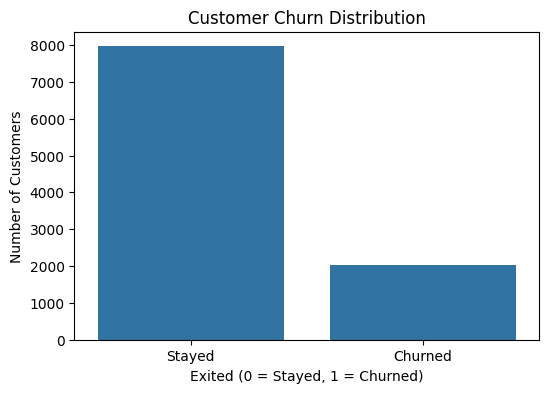

In [43]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Exited', data=churn_df)
plt.title('Customer Churn Distribution')
plt.xlabel('Exited (0 = Stayed, 1 = Churned)')
plt.ylabel('Number of Customers')
plt.xticks([0, 1], ['Stayed', 'Churned'])
plt.show();

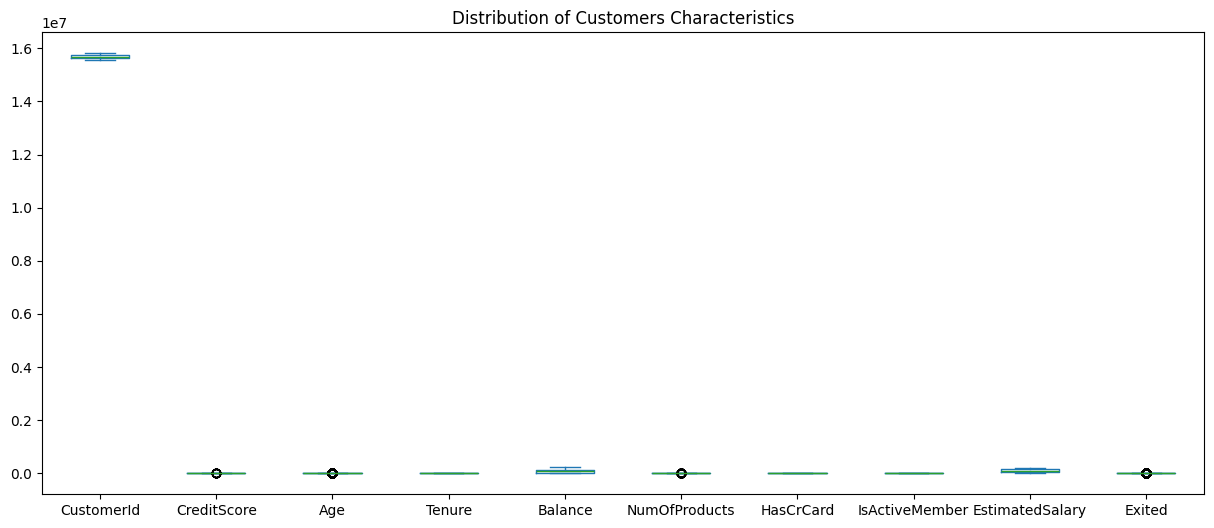

In [77]:
fig, ax = plt.subplots(figsize=(15, 6))
churn_df.plot(kind="box",vert=True,title="Distribution of Customers Characteristics",ax=ax);

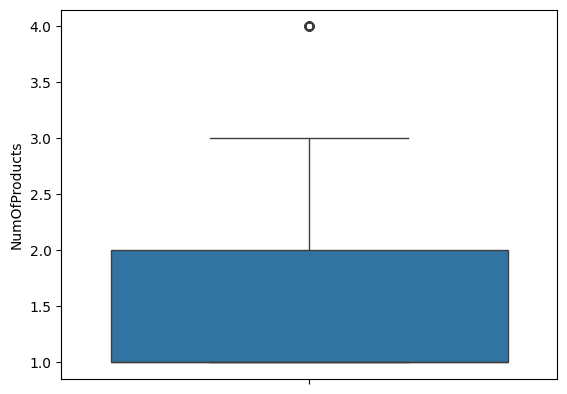

In [78]:
sns.boxplot(churn_df['NumOfProducts']);

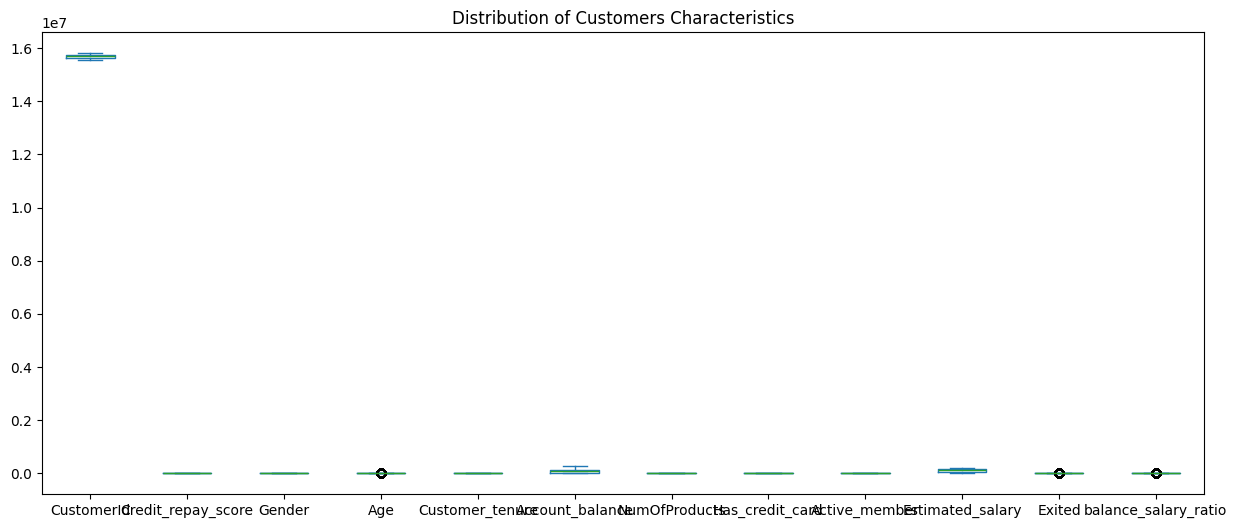

In [85]:
fig, ax = plt.subplots(figsize=(15, 6))
clean_churn_df.plot(kind="box",vert=True,title="Distribution of Customers Characteristics",ax=ax);

In [69]:
clean_churn_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9153 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Credit_repay_score    9153 non-null   float64 
 1   Gender                9153 non-null   int64   
 2   Age                   9153 non-null   float64 
 3   Customer_tenure       9153 non-null   int64   
 4   Account_balance       9153 non-null   float64 
 5   NumOfProducts         9153 non-null   int64   
 6   Has_credit_card       9153 non-null   int64   
 7   Active_member         9153 non-null   int64   
 8   Estimated_salary      9153 non-null   float64 
 9   Exited                9153 non-null   int64   
 10  Country_France        9153 non-null   bool    
 11  Country_Germany       9153 non-null   bool    
 12  Country_Spain         9153 non-null   bool    
 13  age_group             9153 non-null   category
 14  tenure_group          9153 non-null   category
 15  balance_s

In [68]:
clean_churn_df['NumOfProducts']=clean_churn_df['NumOfProducts'].astype(int)

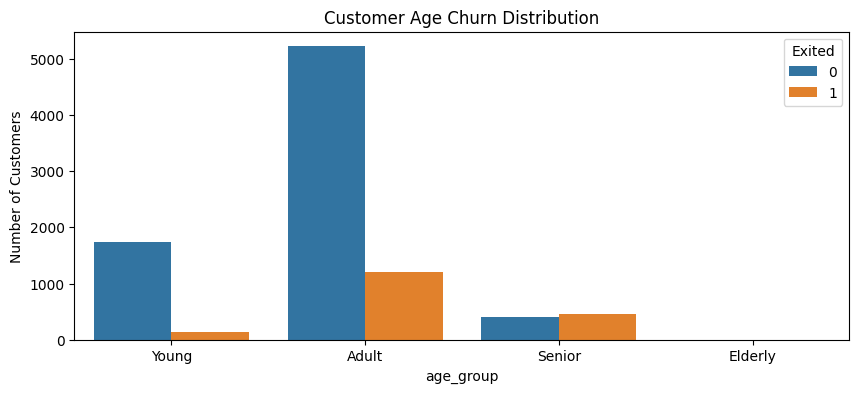

In [12]:
plt.figure(figsize=(10, 4))
sns.countplot(x='age_group', hue='Exited',data=clean_churn_df)
plt.title('Customer Age Churn Distribution')
#plt.xlabel('Exited (0 = Stayed, 1 = Churned)')
plt.ylabel('Number of Customers')
plt.xticks([0,1,2,3], ['Young', 'Adult','Senior','Elderly']) #'Young': 0, 'Adult': 1, 'Senior': 2, 'Elderly': 3
plt.show();

Mostly adults compared to their total number are not prone to leave the bank, but seniors ratio of leaving the bank is higher.

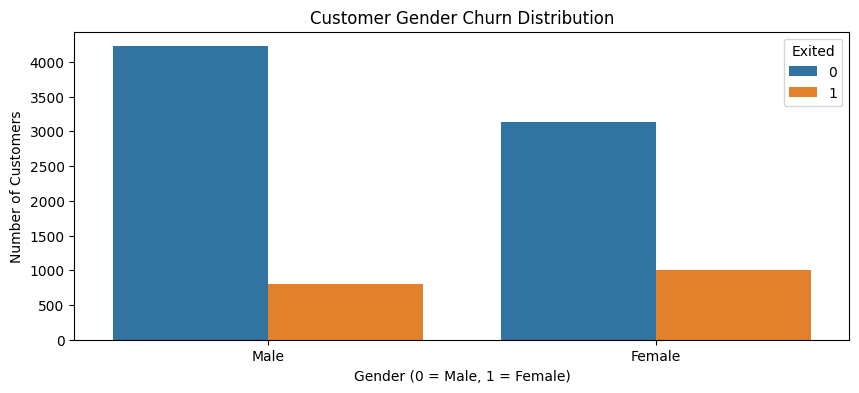

In [21]:
plt.figure(figsize=(10, 4))
sns.countplot(x='Gender', hue='Exited',data=clean_churn_df)
plt.title('Customer Gender Churn Distribution')
plt.xlabel('Gender (0 = Male, 1 = Female)')
plt.ylabel('Number of Customers')
plt.xticks([0,1], ['Male', 'Female'])
plt.show();

If we observe ratio of male and female customers, we find that in every 8 male 1 tends to leave whereas in every 5 female 1 is churned. So not much but females seems to be more churned.

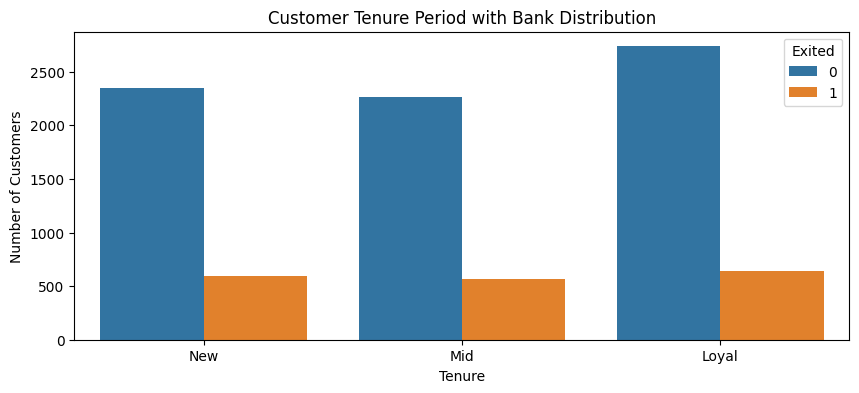

In [15]:
plt.figure(figsize=(10, 4))
sns.countplot(x='tenure_group', hue='Exited',data=clean_churn_df)
plt.title('Customer Tenure Period with Bank- Distribution')
plt.xlabel('Tenure')
plt.ylabel('Number of Customers')
plt.xticks([0,1,2], ['New', 'Mid','Loyal'])
plt.show();

churn rate is mostly same fror all three types of Tenure Group


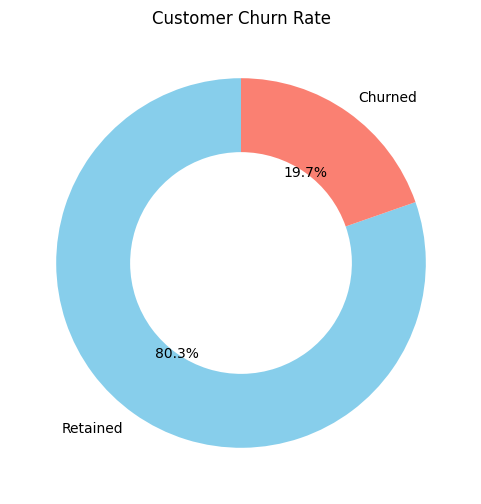

In [7]:
churn_counts = clean_churn_df['Exited'].value_counts()
labels = ['Retained', 'Churned']
colors = ['skyblue', 'salmon']

plt.figure(figsize=(6, 6))
plt.pie(churn_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops={'width': 0.4})
plt.title('Customer Churn Rate')
plt.show()


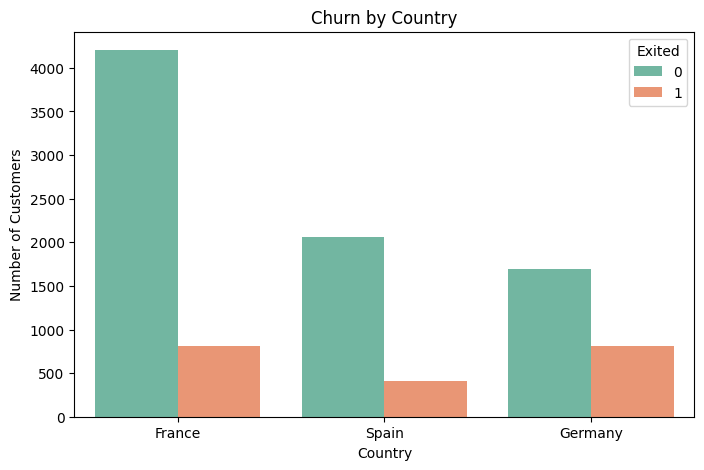

In [13]:
plt.figure(figsize=(8, 5))
sns.countplot(data=churn_df, x='Geography', hue='Exited', palette='Set2')
plt.title('Churn by Country')
plt.xlabel('Country')
plt.ylabel('Number of Customers')
plt.legend(title='Exited')
plt.show()


The analysis reveals that both France and Germany has around 600-700 customers exited. But if ratio is considered customers in France stays more than Germany. In germany customers app out of 1600 customers, about 600 customers exits the bank. So actions should be taken in Germany to retain more customers.

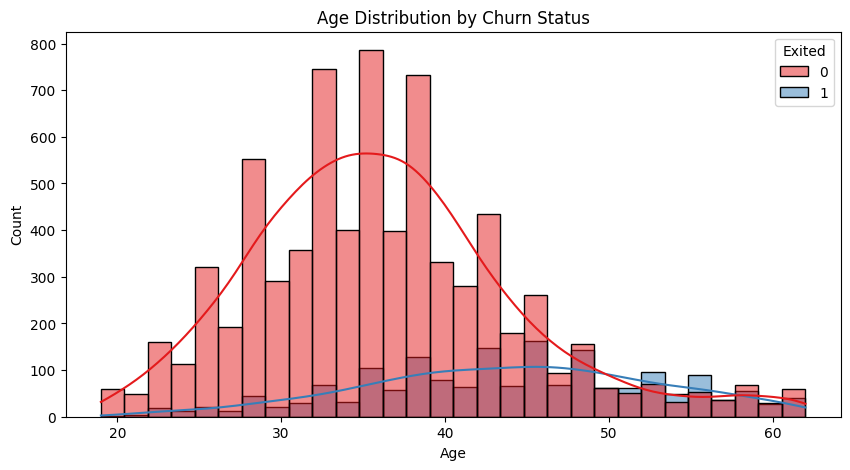

In [14]:
plt.figure(figsize=(10, 5))
sns.histplot(data=clean_churn_df, x='Age', hue='Exited', bins=30, kde=True, palette='Set1')
plt.title('Age Distribution by Churn Status')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()


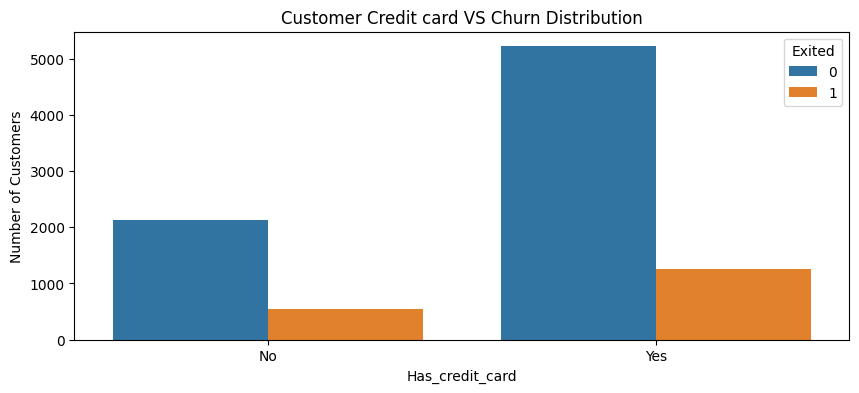

In [56]:
plt.figure(figsize=(10, 4))
sns.countplot(x='Has_credit_card', hue='Exited',data=clean_churn_df)
plt.title('Customer Credit card VS Churn Distribution')
#plt.xlabel('Gender (0 = Male, 1 = Female)')
plt.ylabel('Number of Customers')
plt.xticks([0,1], ['No', 'Yes'])
plt.show();

Churned customers tend to have credit cards.

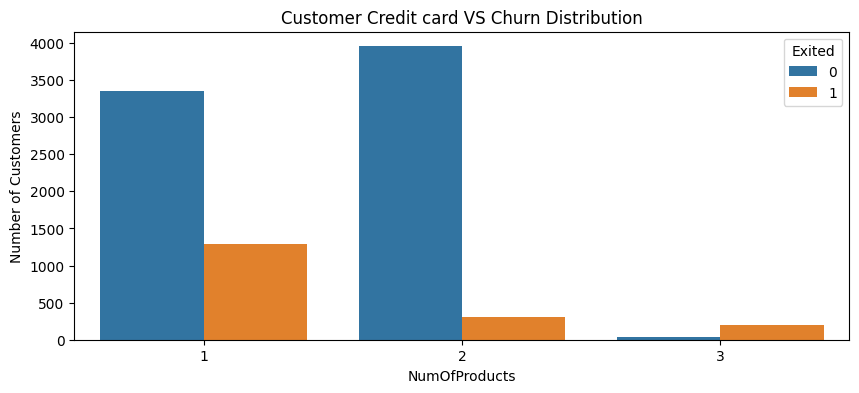

In [71]:
plt.figure(figsize=(10, 4))
sns.countplot(x='NumOfProducts', hue='Exited',data=clean_churn_df)
plt.title('Customer Credit card VS Churn Distribution')
#plt.xlabel('Gender (0 = Male, 1 = Female)')
plt.ylabel('Number of Customers')
#plt.xticks([0,1], ['No', 'Yes'])
plt.show();

The customers that uses 3 services tends to be more churned.

In [19]:
x=clean_churn_df.groupby('Customer_tenure')['Exited'].mean()
print(x)

Customer_tenure
1     0.218496
2     0.184739
3     0.201873
4     0.202944
5     0.200207
6     0.197397
7     0.165489
8     0.187689
9     0.209903
10    0.200431
Name: Exited, dtype: float64


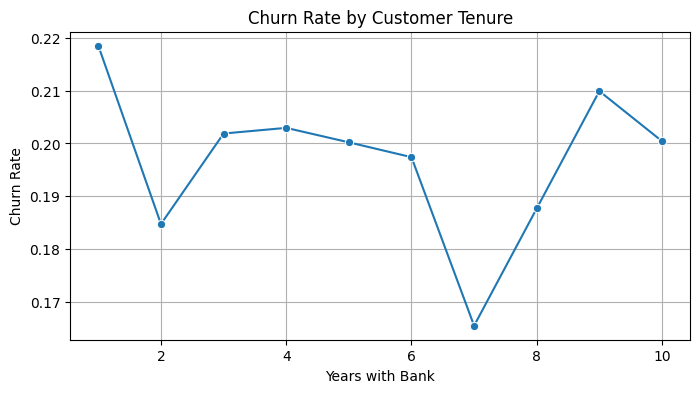

In [16]:
tenure_churn = clean_churn_df.groupby('Customer_tenure')['Exited'].mean().reset_index()
plt.figure(figsize=(8, 4))
sns.lineplot(data=tenure_churn, x='Customer_tenure', y='Exited', marker='o')
plt.title('Churn Rate by Customer Tenure')
plt.xlabel('Years with Bank')
plt.ylabel('Churn Rate')
plt.grid(True)
plt.show()


The churn rate is high in the first years, indicating new customers tend to leave bank more often than the mid tenure customers. The Loyal customers- using services for long-term specifically at the 9th year, tends to have a rise in churn rate.
The bank should have a welcome startegy for new users like- a welcome cashback/ higher interest rates in the firts years/ attractive loan schemes.

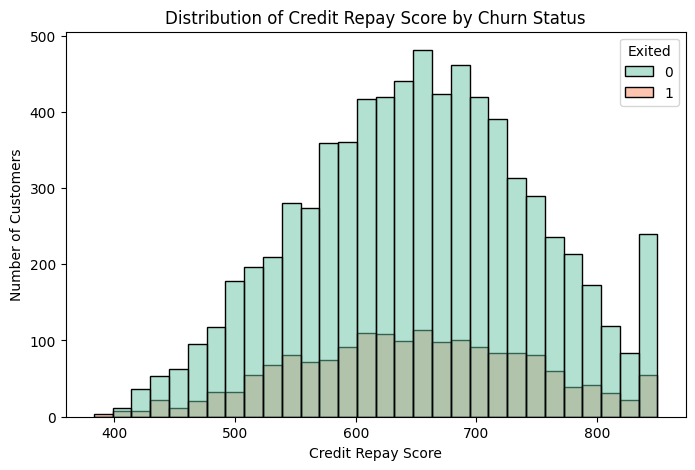

In [25]:
plt.figure(figsize=(8, 5))
sns.histplot(data=clean_churn_df, x='Credit_repay_score', hue='Exited', bins=30, kde=False, palette='Set2')
plt.title('Distribution of Credit Repay Score by Churn Status')
plt.xlabel('Credit Repay Score')
plt.ylabel('Number of Customers')
plt.show()

Not a strong indicator. But we can observe that even customers with high credit scores are churning. Although most of the staying customers have higher credit scores.

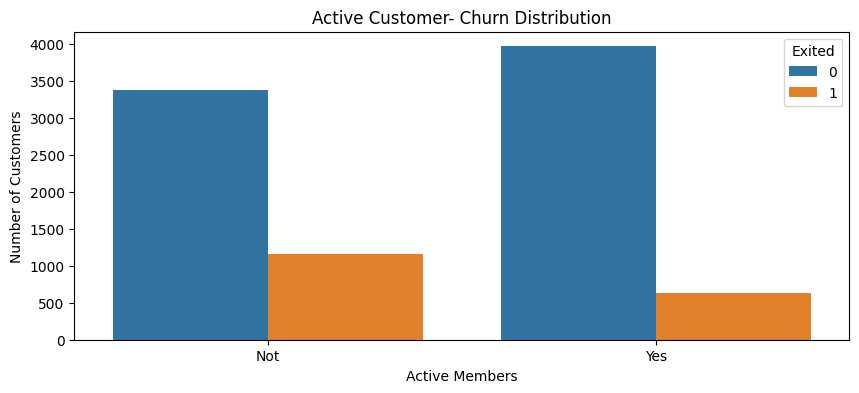

In [29]:
plt.figure(figsize=(10, 4))
sns.countplot(x='Active_member', hue='Exited',data=clean_churn_df)
plt.title('Active Customer- Churn Distribution')
plt.xlabel('Active Members')
plt.ylabel('Number of Customers')
plt.xticks([0,1], ['Not', 'Yes'])
plt.show();

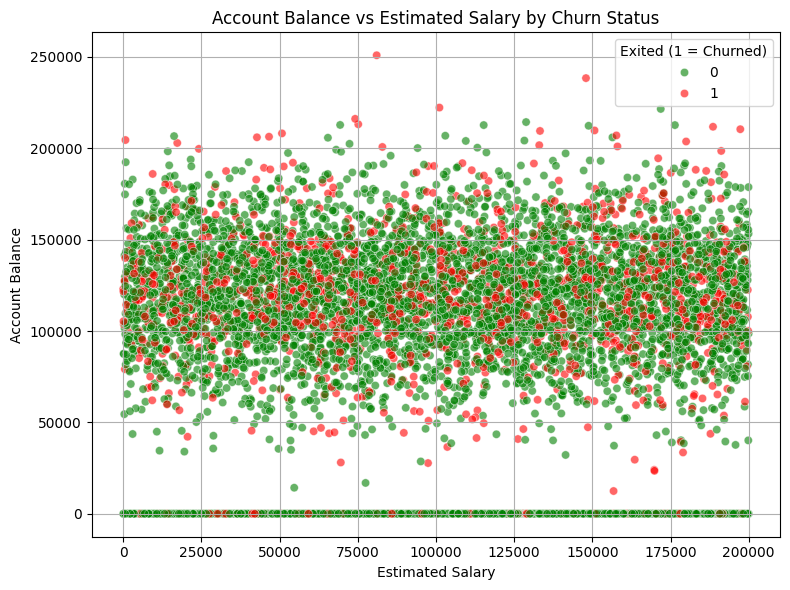

In [47]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=clean_churn_df,
    x='Estimated_salary',
    y='Account_balance',
    hue='Exited',
    palette={0: 'green', 1: 'red'},
    alpha=0.6
)
plt.title('Account Balance vs Estimated Salary by Churn Status')
plt.xlabel('Estimated Salary')
plt.ylabel('Account Balance')
plt.legend(title='Exited (1 = Churned)')
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-52-0aac31178ab0>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




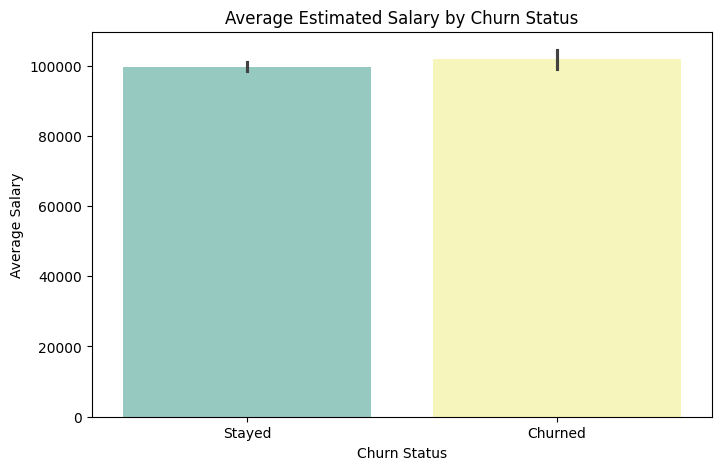

In [52]:
plt.figure(figsize=(8, 5))
sns.barplot(data=clean_churn_df, x='Exited', y='Estimated_salary', palette='Set3')
plt.xticks([0, 1], ['Stayed', 'Churned'])
plt.title('Average Estimated Salary by Churn Status')
plt.xlabel('Churn Status')
plt.ylabel('Average Salary')
plt.show();

<ipython-input-53-c3e9bd9a6885>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




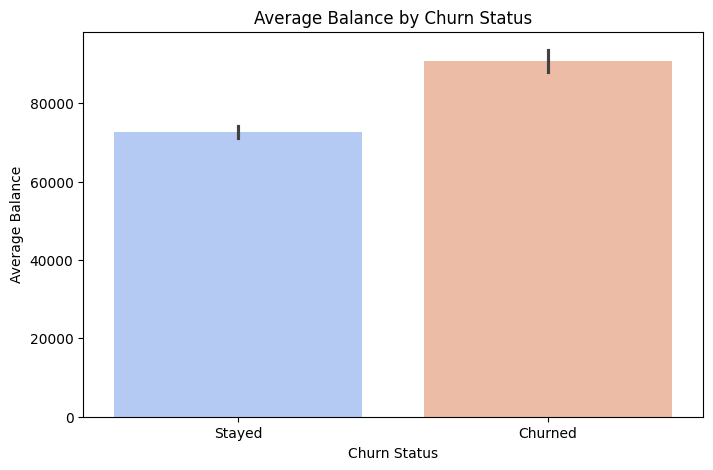

In [53]:
plt.figure(figsize=(8, 5))
sns.barplot(data=clean_churn_df, x='Exited', y='Account_balance',palette='coolwarm')
plt.xticks([0, 1], ['Stayed', 'Churned'])
plt.title('Average Balance by Churn Status')
plt.xlabel('Churn Status')
plt.ylabel('Average Balance')
plt.show()


Those are churned they have more account balance.

<ipython-input-54-de9893dc60dd>:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



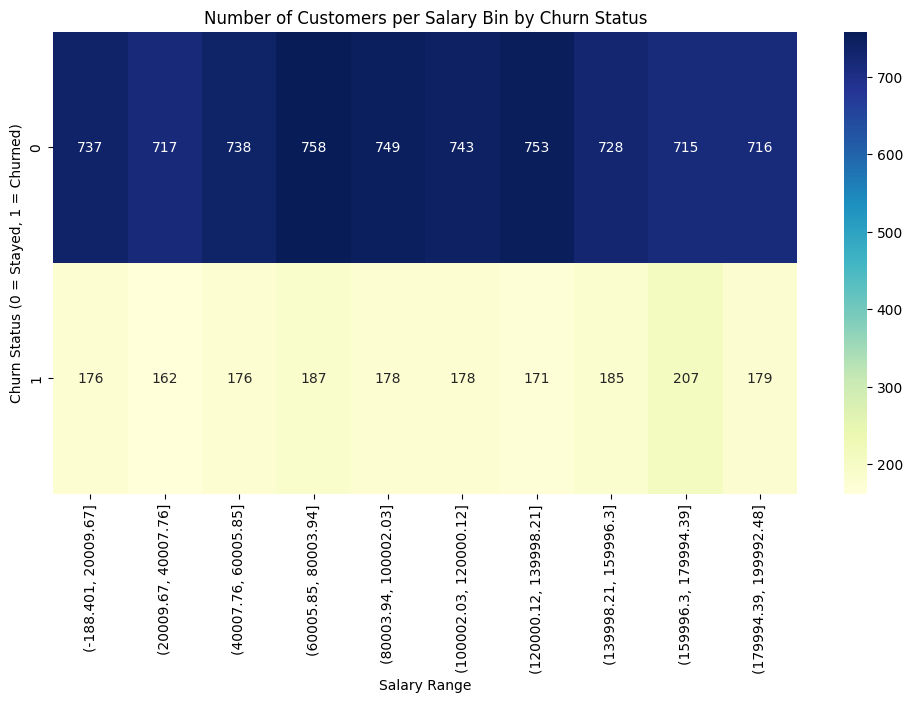

In [54]:
clean_churn_df['salary_bin'] = pd.cut(clean_churn_df['Estimated_salary'], bins=10)
salary_churn = clean_churn_df.groupby(['salary_bin', 'Exited']).size().unstack().fillna(0)

plt.figure(figsize=(12, 6))
sns.heatmap(salary_churn.T, annot=True, fmt='.0f', cmap='YlGnBu')
plt.title('Number of Customers per Salary Bin by Churn Status')
plt.xlabel('Salary Range')
plt.ylabel('Churn Status (0 = Stayed, 1 = Churned)')
plt.show()


Salary is not a predictive feature

In [37]:
import plotly.express as px
plt.figure(figsize=(10,6))
fig = px.scatter(clean_churn_df,
                 x='Age',
                 y='Account_balance',
                 color='Exited',
                 #symbol='Gender',
                 title='Churn by Age, Balance, and Gender',
                 hover_data=['Estimated_salary', 'Customer_tenure'])

fig.show()


<Figure size 1000x600 with 0 Axes>

In [78]:
clean_churn_df.drop(['age_group','tenure_group','balance_salary_ratio'],axis=1)

,Credit_repay_score,Gender,Age,Customer_tenure,Account_balance,NumOfProducts,Has_credit_card,Active_member,Estimated_salary,Exited,Country_France,Country_Germany,Country_Spain
0,619.0,1,42.0,2,0.00,1,1,1,101348.88,1,True,False,False
1,608.0,1,41.0,1,83807.86,1,0,1,112542.58,0,False,False,True
2,502.0,1,42.0,8,159660.80,3,1,0,113931.57,1,True,False,False
3,699.0,1,39.0,1,0.00,2,0,0,93826.63,0,True,False,False
4,850.0,1,43.0,2,125510.82,1,1,1,79084.10,0,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771.0,0,39.0,5,0.00,2,1,0,96270.64,0,True,False,False
9996,516.0,0,35.0,10,57369.61,1,1,1,101699.77,0,True,False,False
9997,709.0,1,36.0,7,0.00,1,0,1,42085.58,1,True,False,False
9998,772.0,0,42.0,3,75075.31,2,1,0,92888.52,1,False,True,False


In [79]:
#splitting
from sklearn.model_selection import train_test_split

X = clean_churn_df.drop('Exited', axis=1)
y = clean_churn_df['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [80]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [81]:
#how can i see the resampling distribution
y_resampled.value_counts()

,count
Exited,
1,5872
0,5872


Original target variable distribution:
Exited
0    7354
1    1799
Name: count, dtype: int64


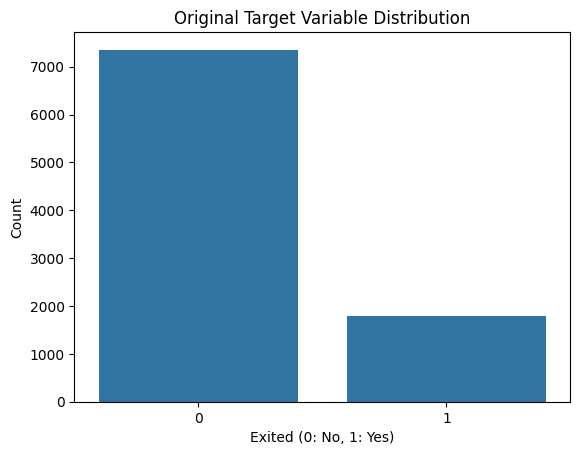


Resampled target variable distribution (after SMOTE):
Exited
1    5872
0    5872
Name: count, dtype: int64


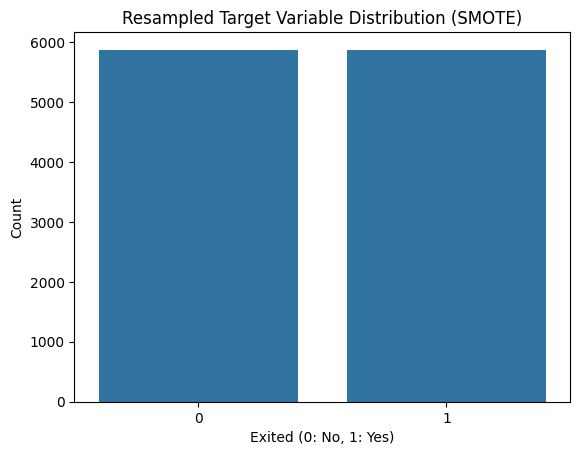

In [75]:

# Check the class distribution in the original data (for comparison)
print("Original target variable distribution:")
print(y.value_counts())
sns.countplot(x=y)
plt.title('Original Target Variable Distribution')
plt.xlabel('Exited (0: No, 1: Yes)')
plt.ylabel('Count')
plt.show()

# Check the class distribution in the resampled data
print("\nResampled target variable distribution (after SMOTE):")
print(y_resampled.value_counts())
sns.countplot(x=y_resampled)
plt.title('Resampled Target Variable Distribution (SMOTE)')
plt.xlabel('Exited (0: No, 1: Yes)')
plt.ylabel('Count')
plt.show()

In [88]:
#model buiding
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report,ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint


In [84]:
rf = RandomForestClassifier()
rf.fit(X_resampled, y_resampled)

RandomForestClassifier()

In [85]:
y_pred = rf.predict(X_test)

In [86]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8623702894593118


In [89]:
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.95      0.92      1482
           1       0.71      0.47      0.57       349

    accuracy                           0.86      1831
   macro avg       0.80      0.71      0.74      1831
weighted avg       0.85      0.86      0.85      1831

Confusion Matrix:
 [[1415   67]
 [ 185  164]]


In [90]:
cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cm.ravel()
specificity = TN / (TN + FP)
print(f'Specificity: {specificity:.2f}')

Specificity: 0.95


Most loyal customers are correctly labeled as such.